In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Image CLS PipeLine _VNEXT

/content/drive/MyDrive/Image CLS PipeLine _VNEXT


In [21]:
# Torch lib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Sklearn lib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Main lib
import os
from PIL import Image
import gc
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
from tqdm.auto import tqdm
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [22]:
@dataclass
class TrainingConfig:
    """Configuration class for training pipeline"""
    # Paths
    data_dir: str = "./Wonders of World Splitting"
    train_dir: str = "./Wonders of World Splitting/train"
    val_dir: str = "./Wonders of World Splitting/valid"
    test_dir: str = "./Wonders of World Splitting/test"
    checkpoint_dir: str = "./checkpoints"
    log_dir: str = "./logs"
    tensorboard_dir: str = "./runs"

    # Model - EfficientNet-B3
    model_name: str = "efficientnet_b3"
    pretrained: bool = True
    num_classes: int = 12  # Update this based on your dataset

    # Training hyperparameters
    batch_size: int = 16  # EfficientNet-B3 is larger, reduce batch size
    num_epochs: int = 100
    learning_rate: float = 0.001
    weight_decay: float = 1e-4
    momentum: float = 0.9

    # Image settings - EfficientNet-B3 optimal input size
    img_size: int = 224  # EfficientNet-B3 works well with 300x300
    target_size: int = 224

    # Optimization
    use_mixed_precision: bool = True
    gradient_clip: float = 1.0
    gradient_accumulation_steps: int = 1

    # Scheduler
    scheduler_type: str = "cosine"  # cosine, step, reduce_on_plateau
    t_max: int = 100
    eta_min: float = 1e-6
    warmup_epochs: int = 5

    # Early Stopping - ENABLED
    early_stopping: bool = True
    patience: int = 15
    min_delta: float = 0.0001

    # Checkpointing
    save_best_only: bool = True
    save_last: bool = True
    save_frequency: int = 10

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2  # For Colab/Kaggle
    pin_memory: bool = True

    # Random seed
    seed: int = 42

    # Experiment tracking
    experiment_name: str = f"efficientnet_b3_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    def __post_init__(self):
        """Create necessary directories"""
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
        Path(self.log_dir).mkdir(parents=True, exist_ok=True)
        Path(self.tensorboard_dir).mkdir(parents=True, exist_ok=True)

    def save(self, path: str):
        """Save configuration to JSON"""
        with open(path, 'w') as f:
            json.dump(asdict(self), f, indent=4)

    @classmethod
    def load(cls, path: str):
        """Load configuration from JSON"""
        with open(path, 'r') as f:
            config_dict = json.load(f)
        return cls(**config_dict)

In [23]:
class TensorBoardLogger:
    """TensorBoard logger for training metrics"""
    def __init__(self, log_dir: str, experiment_name: str):
        self.writer = SummaryWriter(log_dir=f"{log_dir}/{experiment_name}")
        self.experiment_name = experiment_name

    def log_scalars(self, metrics: Dict[str, float], step: int, prefix: str = ""):
        """Log scalar metrics"""
        for key, value in metrics.items():
            tag = f"{prefix}/{key}" if prefix else key
            self.writer.add_scalar(tag, value, step)

    def log_learning_rate(self, lr: float, step: int):
        """Log learning rate"""
        self.writer.add_scalar('learning_rate', lr, step)

    def log_images(self, images: torch.Tensor, step: int, tag: str = "images", max_images: int = 8):
        """Log images to TensorBoard"""
        # Denormalize images
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        images = images[:max_images].cpu() * std + mean
        images = torch.clamp(images, 0, 1)

        self.writer.add_images(tag, images, step)

    def log_confusion_matrix(self, cm: np.ndarray, class_names: List[str], step: int):
        """Log confusion matrix as image"""
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        ax.set_title('Confusion Matrix')

        self.writer.add_figure('confusion_matrix', fig, step)
        plt.close(fig)

    def log_model_graph(self, model: nn.Module, input_size: tuple, device: torch.device):
        """Log model architecture"""
        dummy_input = torch.randn(1, *input_size)
        try:
            self.writer.add_graph(model, dummy_input).to(device)
        except Exception as e:
            print(f"Could not log model graph: {e}")

    def log_histogram(self, model: nn.Module, step: int):
        """Log model parameters histogram"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.writer.add_histogram(f'parameters/{name}', param, step)
                if param.grad is not None:
                    self.writer.add_histogram(f'gradients/{name}', param.grad, step)

    def close(self):
        """Close the writer"""
        self.writer.close()

In [24]:
class MetricsLogger:
    """Logger for saving training metrics to JSON"""
    def __init__(self, log_dir: str, experiment_name: str):
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        self.experiment_name = experiment_name
        self.metrics = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epochs': []
        }

    def log(self, epoch: int, metrics: Dict):
        """Log metrics for an epoch"""
        self.metrics['epochs'].append(epoch)
        for key, value in metrics.items():
            if key in self.metrics:
                self.metrics[key].append(float(value))

    def save(self):
        """Save metrics to JSON file"""
        filename = f"metrics_{self.experiment_name}.json"
        with open(self.log_dir / filename, 'w') as f:
            json.dump(self.metrics, f, indent=4)
        print(f"✓ Metrics saved to {self.log_dir / filename}")

    def plot_metrics(self, save_path: Optional[str] = None):
        """Plot training metrics"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        epochs = self.metrics['epochs']

        # Plot loss
        axes[0].plot(epochs, self.metrics['train_loss'], label='Train Loss',
                    marker='o', linewidth=2, markersize=4)
        axes[0].plot(epochs, self.metrics['val_loss'], label='Val Loss',
                    marker='s', linewidth=2, markersize=4)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot accuracy
        axes[1].plot(epochs, [acc*100 for acc in self.metrics['train_acc']],
                    label='Train Acc', marker='o', linewidth=2, markersize=4)
        axes[1].plot(epochs, [acc*100 for acc in self.metrics['val_acc']],
                    label='Val Acc', marker='s', linewidth=2, markersize=4)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Accuracy (%)', fontsize=12)
        axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Metrics plot saved to {save_path}")
        plt.show()

In [25]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience: int = 15, min_delta: float = 0.0001, mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, score: float, epoch: int) -> bool:
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return False

        if self.mode == 'min':
            improved = score < (self.best_score - self.min_delta)
        else:
            improved = score > (self.best_score + self.min_delta)

        if improved:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            print(f"  EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True

        return False

In [26]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
    """Count trainable and total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

In [28]:
def resize_with_padding(img: Image.Image, target_size: int = 280,
                       output_size: int = 300) -> Image.Image:
    """Resize image maintaining aspect ratio and add padding"""
    img_width, img_height = img.size

    # Calculate resize ratio
    if img_width > img_height:
        new_width = target_size
        new_height = int((target_size / img_width) * img_height)
    else:
        new_height = target_size
        new_width = int((target_size / img_height) * img_width)

    # Resize image
    img = img.resize((new_width, new_height), Image.LANCZOS)

    # Create square canvas with gray background
    square_img = Image.new('RGB', (output_size, output_size), (114, 114, 114))

    # Center the image
    x_offset = (output_size - new_width) // 2
    y_offset = (output_size - new_height) // 2
    square_img.paste(img, (x_offset, y_offset))

    return square_img

In [29]:
class ImageClassificationDataset(Dataset):
    """Custom dataset for image classification with detailed statistics"""
    def __init__(self, root_dir: str, transform=None, class_names: List[str] = None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # Auto-detect class names if not provided
        if class_names is None:
            self.class_names = sorted([d.name for d in self.root_dir.iterdir()
                                      if d.is_dir() and not d.name.startswith('.')])
        else:
            self.class_names = class_names

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Collect all image paths and labels
        self.samples = []
        self._load_samples()

    def _load_samples(self):
        """Load all image paths and corresponding labels"""
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            if not class_dir.exists():
                print(f"Warning: Class directory {class_dir} does not exist")
                continue

            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in valid_extensions:
                    self.samples.append((str(img_path), self.class_to_idx[class_name]))

        if len(self.samples) == 0:
            raise ValueError(f"No valid images found in {self.root_dir}")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path, label = self.samples[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image in case of error
            image = Image.new('RGB', (300, 300), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self) -> Dict[str, int]:
        """Get distribution of samples per class"""
        distribution = {cls_name: 0 for cls_name in self.class_names}
        for _, label in self.samples:
            class_name = self.class_names[label]
            distribution[class_name] += 1
        return distribution

    def print_statistics(self):
        """Print dataset statistics"""
        print(f"\n{'='*70}")
        print(f"Dataset Statistics: {self.root_dir.name}")
        print(f"{'='*70}")
        print(f"Total samples: {len(self.samples)}")
        print(f"Number of classes: {len(self.class_names)}")
        print(f"\nClass distribution:")

        distribution = self.get_class_distribution()
        for cls_name, count in distribution.items():
            percentage = (count / len(self.samples)) * 100
            print(f"  {cls_name:30s}: {count:5d} ({percentage:5.2f}%)")
        print(f"{'='*70}\n")

In [30]:
def get_train_transforms(img_size: int = 300) -> transforms.Compose:
    """Get training data augmentation transforms optimized for EfficientNet-B3"""
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(img_size, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [31]:
def get_val_transforms(img_size: int = 300) -> transforms.Compose:
    """Get validation/test transforms"""
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [32]:
class EfficientNetB3Classifier(nn.Module):
    """EfficientNet-B3 with custom classifier head"""
    def __init__(self, num_classes: int, pretrained: bool = True, dropout: float = 0.3):
        super(EfficientNetB3Classifier, self).__init__()

        # Load pretrained EfficientNet-B3
        self.backbone = models.efficientnet_b3(pretrained=pretrained)

        # Get number of features from the last layer
        in_features = self.backbone.classifier[1].in_features

        # Custom classifier head with dropout
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        """Freeze backbone for transfer learning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = True

In [33]:
def build_model(num_classes: int, pretrained: bool = True, dropout: float = 0.3) -> nn.Module:
    """Build EfficientNet-B3 model"""
    model = EfficientNetB3Classifier(num_classes, pretrained, dropout)
    return model

In [34]:
class Trainer:
    """Main trainer class with TensorBoard integration"""

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device(config.device)

        # Set random seed
        set_seed(config.seed)

        # Initialize components
        self.model = None
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.scaler = None

        # Logging
        self.tb_logger = TensorBoardLogger(config.tensorboard_dir, config.experiment_name)
        self.metrics_logger = MetricsLogger(config.log_dir, config.experiment_name)

        # Early stopping
        self.early_stopping = EarlyStopping(
            patience=config.patience,
            min_delta=config.min_delta,
            mode='min'
        ) if config.early_stopping else None

        # Best model tracking
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
        self.best_epoch = 0

        # Global step for TensorBoard
        self.global_step = 0

    def setup_model(self, num_classes: int):
        """Setup model, criterion, optimizer, and scheduler"""
        # Build EfficientNet-B3 model
        self.model = build_model(
            num_classes=num_classes,
            pretrained=self.config.pretrained,
            dropout=0.3
        )
        self.model = self.model.to(self.device)

        trainable, total = count_parameters(self.model)
        print(f"\n{'='*70}")
        print(f"Model: {self.config.model_name}")
        print(f"Total parameters: {total:,}")
        print(f"Trainable parameters: {trainable:,}")
        print(f"{'='*70}\n")

        # Log model architecture to TensorBoard
        self.tb_logger.log_model_graph(self.model, (3, self.config.img_size, self.config.img_size), self.device)

        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Optimizer - AdamW works well with EfficientNet
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )

        # Scheduler
        if self.config.scheduler_type == "cosine":
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=self.config.t_max,
                eta_min=self.config.eta_min
            )
        elif self.config.scheduler_type == "step":
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=15,
                gamma=0.1
            )
        elif self.config.scheduler_type == "reduce_on_plateau":
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                factor=0.5,
                patience=5,
                verbose=True
            )

        # Mixed precision scaler
        if self.config.use_mixed_precision and self.device.type == 'cuda':
            self.scaler = torch.cuda.amp.GradScaler()
        else:
            self.scaler = None

    def train_epoch(self, train_loader: DataLoader, epoch: int) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs} [TRAIN]")

        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            batch_size = labels.size(0)
            total_samples += batch_size

            # Zero gradients
            self.optimizer.zero_grad()

            # Mixed precision training
            if self.scaler:
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                self.scaler.scale(loss).backward()

                if self.config.gradient_clip > 0:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(),
                        self.config.gradient_clip
                    )

                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                if self.config.gradient_clip > 0:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(),
                        self.config.gradient_clip
                    )

                self.optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels).item()

            # Update progress bar
            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}'
            })

            # Log to TensorBoard every 10 batches
            if batch_idx % 10 == 0:
                self.tb_logger.log_scalars({
                    'batch_loss': loss.item(),
                    'batch_acc': torch.sum(preds == labels).item() / batch_size
                }, self.global_step, 'train')

            self.global_step += 1

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        return epoch_loss, epoch_acc

    def validate(self, val_loader: DataLoader, epoch: int) -> Tuple[float, float]:
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        all_preds = []
        all_labels = []

        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs} [VAL]  ")

        with torch.no_grad():
            for inputs, labels in pbar:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                batch_size = labels.size(0)
                total_samples += batch_size

                # Forward pass
                if self.scaler:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                # Statistics
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels).item()

                # Collect predictions for confusion matrix
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar
                current_loss = running_loss / total_samples
                current_acc = running_corrects / total_samples
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'acc': f'{current_acc:.4f}'
                })

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        return epoch_loss, epoch_acc, all_preds, all_labels

    def save_checkpoint(self, epoch: int, val_loss: float, val_acc: float,
                       is_best: bool = False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'best_val_loss': self.best_val_loss,
            'best_val_acc': self.best_val_acc,
            'config': asdict(self.config)
        }

        if self.scaler:
            checkpoint['scaler_state_dict'] = self.scaler.state_dict()

        checkpoint_dir = Path(self.config.checkpoint_dir)

        # Save best model
        if is_best:
            save_path = checkpoint_dir / 'best_model.pth'
            torch.save(checkpoint, save_path)
            print(f"  ✓ Best model saved! Val Acc: {val_acc:.4f}")

        # Save last model
        if self.config.save_last:
            save_path = checkpoint_dir / 'last_model.pth'
            torch.save(checkpoint, save_path)

        # Save periodic checkpoints
        if not self.config.save_best_only:
            if (epoch + 1) % self.config.save_frequency == 0:
                save_path = checkpoint_dir / f'checkpoint_epoch_{epoch+1:03d}.pth'
                torch.save(checkpoint, save_path)

    def load_checkpoint(self, checkpoint_path: str) -> int:
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        if self.scaler and 'scaler_state_dict' in checkpoint:
            self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        self.best_val_acc = checkpoint.get('best_val_acc', 0.0)

        print(f"\n✓ Checkpoint loaded from {checkpoint_path}")
        print(f"  Epoch: {checkpoint['epoch'] + 1}")
        print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
        print(f"  Val Acc: {checkpoint['val_acc']:.4f}")
        print(f"  Best Val Acc: {self.best_val_acc:.4f}\n")

        return checkpoint['epoch']

    def fit(self, train_loader: DataLoader, val_loader: DataLoader,
            class_names: List[str], resume_from: Optional[str] = None):
        """Main training loop"""
        start_epoch = 0

        # Resume from checkpoint if provided
        if resume_from and os.path.exists(resume_from):
            start_epoch = self.load_checkpoint(resume_from) + 1

        # Print training configuration
        print(f"\n{'='*70}")
        print(f"Training Configuration - {self.config.experiment_name}")
        print(f"{'='*70}")
        print(f"Model: {self.config.model_name}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.config.num_epochs}")
        print(f"Batch Size: {self.config.batch_size}")
        print(f"Learning Rate: {self.config.learning_rate}")
        print(f"Image Size: {self.config.img_size}x{self.config.img_size}")
        print(f"Mixed Precision: {self.config.use_mixed_precision}")
        print(f"Early Stopping: {self.config.early_stopping} (patience={self.config.patience})")
        print(f"Scheduler: {self.config.scheduler_type}")
        print(f"{'='*70}\n")

        # Save configuration
        self.config.save(Path(self.config.log_dir) / f"config_{self.config.experiment_name}.json")

        # Training loop
        for epoch in range(start_epoch, self.config.num_epochs):
            print(f"\n{'='*70}")
            print(f"Epoch {epoch+1}/{self.config.num_epochs}")
            print(f"{'='*70}")

            # Train
            train_loss, train_acc = self.train_epoch(train_loader, epoch)

            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate(val_loader, epoch)

            # Update scheduler
            if self.config.scheduler_type == "reduce_on_plateau":
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']

            # Log to TensorBoard
            self.tb_logger.log_scalars({
                'loss': train_loss,
                'accuracy': train_acc
            }, epoch, 'train')

            self.tb_logger.log_scalars({
                'loss': val_loss,
                'accuracy': val_acc
            }, epoch, 'validation')

            self.tb_logger.log_learning_rate(current_lr, epoch)

            # Log confusion matrix every 10 epochs
            if (epoch + 1) % 10 == 0:
                cm = confusion_matrix(val_labels, val_preds)
                self.tb_logger.log_confusion_matrix(cm, class_names, epoch)

            # Log model parameters histogram every 20 epochs
            if (epoch + 1) % 20 == 0:
                self.tb_logger.log_histogram(self.model, epoch)

            # Log to metrics logger
            self.metrics_logger.log(epoch, {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rates': current_lr
            })

            # Print epoch summary
            print(f"\n{'─'*70}")
            print(f"Epoch {epoch+1} Summary:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
            print(f"  Learning Rate: {current_lr:.6f}")

            # Save best model
            is_best = val_acc > self.best_val_acc
            if is_best:
                self.best_val_loss = val_loss
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                print(f"  🏆 New best model!")

            self.save_checkpoint(epoch, val_loss, val_acc, is_best)

            # Early stopping
            if self.early_stopping:
                if self.early_stopping(val_loss, epoch):
                    print(f"\n{'='*70}")
                    print(f"⚠ Early stopping triggered at epoch {epoch+1}")
                    print(f"  Best epoch: {self.best_epoch+1}")
                    print(f"  Best val_acc: {self.best_val_acc*100:.2f}%")
                    print(f"  Best val_loss: {self.best_val_loss:.4f}")
                    print(f"{'='*70}\n")
                    break

            print(f"{'─'*70}")

            # Clear cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        # Save final metrics
        self.metrics_logger.save()

        # Plot and save metrics
        plot_path = Path(self.config.log_dir) / f"metrics_plot_{self.config.experiment_name}.png"
        self.metrics_logger.plot_metrics(str(plot_path))

        # Close TensorBoard writer
        self.tb_logger.close()

        print(f"\n{'='*70}")
        print(f"✓ Training completed!")
        print(f"  Best Val Acc: {self.best_val_acc*100:.2f}% at epoch {self.best_epoch+1}")
        print(f"  Best Val Loss: {self.best_val_loss:.4f}")
        print(f"  Checkpoints saved to: {self.config.checkpoint_dir}")
        print(f"  Logs saved to: {self.config.log_dir}")
        print(f"  TensorBoard logs: {self.config.tensorboard_dir}/{self.config.experiment_name}")
        print(f"{'='*70}\n")

In [35]:
class Evaluator:
    """Model evaluation class with comprehensive metrics"""

    def __init__(self, model: nn.Module, device: torch.device, class_names: List[str]):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.model.eval()

    def evaluate(self, test_loader: DataLoader) -> Dict:
        """Evaluate model on test set"""
        all_preds = []
        all_labels = []
        all_probs = []

        print("\n" + "="*70)
        print("Evaluating model on test set...")
        print("="*70)

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(
            all_labels, all_preds,
            target_names=self.class_names,
            output_dict=True
        )

        results = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': report,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs
        }

        # Print results
        print(f"\n{'='*70}")
        print(f"Test Accuracy: {accuracy*100:.2f}%")
        print(f"{'='*70}\n")

        return results

    def plot_confusion_matrix(self, cm: np.ndarray, save_path: Optional[str] = None,
                             normalize: bool = False):
        """Plot confusion matrix"""
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
            title = 'Normalized Confusion Matrix'
        else:
            fmt = 'd'
            title = 'Confusion Matrix'

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm, annot=True, fmt=fmt, cmap='Blues',
            xticklabels=self.class_names,
            yticklabels=self.class_names,
            cbar_kws={'label': 'Count' if not normalize else 'Proportion'}
        )
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Confusion matrix saved to {save_path}")
        plt.show()

    def print_classification_report(self, report: Dict):
        """Print detailed classification report"""
        print("\n" + "="*70)
        print("Classification Report:")
        print("="*70)

        df = pd.DataFrame(report).transpose()

        # Format the dataframe
        if 'support' in df.columns:
            df['support'] = df['support'].astype(int)

        print(df.to_string())
        print("="*70 + "\n")

    def plot_per_class_metrics(self, report: Dict, save_path: Optional[str] = None):
        """Plot per-class precision, recall, and F1-score"""
        # Extract per-class metrics
        classes = [c for c in report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
        precision = [report[c]['precision'] for c in classes]
        recall = [report[c]['recall'] for c in classes]
        f1_score = [report[c]['f1-score'] for c in classes]

        # Create plot
        x = np.arange(len(classes))
        width = 0.25

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
        ax.bar(x, recall, width, label='Recall', alpha=0.8)
        ax.bar(x + width, f1_score, width, label='F1-Score', alpha=0.8)

        ax.set_xlabel('Classes', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.1])

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Per-class metrics plot saved to {save_path}")
        plt.show()

    def save_predictions(self, predictions: List[int], labels: List[int],
                        probabilities: List[np.ndarray], save_path: str):
        """Save predictions to CSV file"""
        df = pd.DataFrame({
            'true_label': [self.class_names[l] for l in labels],
            'predicted_label': [self.class_names[p] for p in predictions],
            'correct': [l == p for l, p in zip(labels, predictions)]
        })

        # Add probability for each class
        for i, class_name in enumerate(self.class_names):
            df[f'prob_{class_name}'] = [prob[i] for prob in probabilities]

        df.to_csv(save_path, index=False)
        print(f"✓ Predictions saved to {save_path}")

In [36]:
class Predictor:
    """Single image prediction class"""

    def __init__(self, model: nn.Module, device: torch.device,
                 class_names: List[str], transform: transforms.Compose):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.transform = transform
        self.model.eval()

    def predict_single_image(self, image_path: str, top_k: int = 3) -> Dict:
        """Predict single image with top-k probabilities"""
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probs = F.softmax(outputs, dim=1)
            top_probs, top_indices = torch.topk(probs, top_k)

        # Prepare results
        results = {
            'image_path': image_path,
            'predictions': []
        }

        for prob, idx in zip(top_probs[0], top_indices[0]):
            results['predictions'].append({
                'class': self.class_names[idx.item()],
                'probability': prob.item()
            })

        return results

    def visualize_prediction(self, image_path: str, top_k: int = 3):
        """Visualize prediction with image and top-k probabilities"""
        # Get predictions
        results = self.predict_single_image(image_path, top_k)

        # Load image
        img = Image.open(image_path)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Show image
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title('Input Image', fontsize=14, fontweight='bold')

        # Show predictions
        classes = [pred['class'] for pred in results['predictions']]
        probs = [pred['probability'] for pred in results['predictions']]

        y_pos = np.arange(len(classes))
        ax2.barh(y_pos, probs, alpha=0.8)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(classes)
        ax2.invert_yaxis()
        ax2.set_xlabel('Probability', fontsize=12)
        ax2.set_title(f'Top-{top_k} Predictions', fontsize=14, fontweight='bold')
        ax2.set_xlim([0, 1])
        ax2.grid(True, alpha=0.3, axis='x')

        # Add probability values on bars
        for i, prob in enumerate(probs):
            ax2.text(prob + 0.02, i, f'{prob:.3f}',
                    va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

        return results

In [42]:
def main():
    """Main execution function"""

    # ========== CONFIGURATION ==========
    config = TrainingConfig(
        # Paths
        data_dir="./Wonders of World Splitting",
        train_dir="./Wonders of World Splitting/train",
        val_dir="./Wonders of World Splitting/valid",
        test_dir="./Wonders of World Splitting/test",
        checkpoint_dir="./checkpoints",
        log_dir="./logs",
        tensorboard_dir="./runs",

        # Model
        model_name="efficientnet_b3",
        pretrained=True,
        num_classes=12,

        # Training
        batch_size=32,
        num_epochs=5,
        learning_rate=0.001,
        weight_decay=1e-4,

        # Image
        img_size=224,
        target_size=224,

        # Optimization
        use_mixed_precision=True,
        gradient_clip=1.0,

        # Scheduler
        scheduler_type="cosine",
        t_max=100,
        eta_min=1e-6,

        # Early Stopping
        early_stopping=True,
        patience=15,
        min_delta=0.0001,

        # Device
        num_workers=4,
        seed=42,

        # Experiment name
        experiment_name=f"efficientnet_b3_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )

    print("\n" + "="*70)
    print("IMAGE CLASSIFICATION PIPELINE - EfficientNet-B3")
    print("="*70)

    # ========== DATA PREPARATION ==========
    print("\n[1/6] Loading datasets...")

    # Transforms
    train_transform = get_train_transforms(config.img_size)
    val_transform = get_val_transforms(config.img_size)

    # Datasets
    train_dataset = ImageClassificationDataset(
        config.train_dir,
        transform=train_transform
    )
    val_dataset = ImageClassificationDataset(
        config.val_dir,
        transform=val_transform,
        class_names=train_dataset.class_names
    )

    # Update num_classes in config
    config.num_classes = len(train_dataset.class_names)

    # Print statistics
    train_dataset.print_statistics()
    val_dataset.print_statistics()

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )

    print(f"✓ Data loaders created")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")

    # ========== MODEL SETUP ==========
    print("\n[2/6] Setting up model...")

    trainer = Trainer(config)
    trainer.setup_model(config.num_classes)

    # ========== TRAINING ==========
    print("\n[3/6] Starting training...")
    print(f"\n💡 TIP: Monitor training with TensorBoard:")
    print(f"   tensorboard --logdir={config.tensorboard_dir}")
    print(f"   Then open: http://localhost:6006\n")

    trainer.fit(
        train_loader,
        val_loader,
        train_dataset.class_names,
        resume_from=None  # Set to checkpoint path to resume training
    )

    # ========== LOAD BEST MODEL ==========
    print("\n[4/6] Loading best model for evaluation...")

    best_model_path = Path(config.checkpoint_dir) / "best_model.pth"
    if best_model_path.exists():
        trainer.load_checkpoint(str(best_model_path))

    # ========== EVALUATION ON TEST SET ==========
    print("\n[5/6] Evaluating on test set...")

    if Path(config.test_dir).exists():
        # Load test dataset
        test_dataset = ImageClassificationDataset(
            config.test_dir,
            transform=val_transform,
            class_names=train_dataset.class_names
        )
        test_dataset.print_statistics()

        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=config.num_workers,
            pin_memory=config.pin_memory
        )

        # Evaluate
        evaluator = Evaluator(
            trainer.model,
            trainer.device,
            train_dataset.class_names
        )

        results = evaluator.evaluate(test_loader)

        # Print classification report
        evaluator.print_classification_report(results['classification_report'])

        # Plot confusion matrix
        cm_path = Path(config.log_dir) / f"confusion_matrix_{config.experiment_name}.png"
        evaluator.plot_confusion_matrix(
            results['confusion_matrix'],
            save_path=str(cm_path)
        )

        # Plot per-class metrics
        metrics_path = Path(config.log_dir) / f"per_class_metrics_{config.experiment_name}.png"
        evaluator.plot_per_class_metrics(
            results['classification_report'],
            save_path=str(metrics_path)
        )

        # Save predictions
        pred_path = Path(config.log_dir) / f"predictions_{config.experiment_name}.csv"
        evaluator.save_predictions(
            results['predictions'],
            results['labels'],
            results['probabilities'],
            str(pred_path)
        )
    else:
        print(f"⚠ Test directory not found: {config.test_dir}")
        print("  Skipping test evaluation.")

    # ========== DEMO PREDICTION ==========
    print("\n[6/6] Demo: Single image prediction")

    # Example: Predict a single image
    # predictor = Predictor(
    #     trainer.model,
    #     trainer.device,
    #     train_dataset.class_names,
    #     val_transform
    # )
    #
    # image_path = "path/to/your/image.jpg"
    # predictor.visualize_prediction(image_path, top_k=5)

    print("\n" + "="*70)
    print("✅ Pipeline execution completed successfully!")
    print("="*70)
    print(f"\n📁 Outputs:")
    print(f"  • Checkpoints: {config.checkpoint_dir}")
    print(f"  • Logs: {config.log_dir}")
    print(f"  • TensorBoard: {config.tensorboard_dir}/{config.experiment_name}")
    print(f"\n🔍 To view TensorBoard:")
    print(f"  tensorboard --logdir={config.tensorboard_dir}")
    print("="*70 + "\n")


IMAGE CLASSIFICATION PIPELINE - EfficientNet-B3

[1/6] Loading datasets...

Dataset Statistics: train
Total samples: 2686
Number of classes: 12

Class distribution:
  burj_khalifa                  :   273 (10.16%)
  chichen_itza                  :   237 ( 8.82%)
  christ_the_reedemer           :   226 ( 8.41%)
  eiffel_tower                  :   273 (10.16%)
  great_wall_of_china           :   274 (10.20%)
  machu_pichu                   :   275 (10.24%)
  pyramids_of_giza              :   260 ( 9.68%)
  roman_colosseum               :   275 (10.24%)
  statue_of_liberty             :   166 ( 6.18%)
  stonehenge                    :   142 ( 5.29%)
  taj_mahal                     :   110 ( 4.10%)
  venezuela_angel_falls         :   175 ( 6.52%)


Dataset Statistics: valid
Total samples: 764
Number of classes: 12

Class distribution:
  burj_khalifa                  :    78 (10.21%)
  chichen_itza                  :    68 ( 8.90%)
  christ_the_reedemer           :    64 ( 8.38%)
  eiffel_

Epoch 1/5 [TRAIN]:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/5 [VAL]  :   0%|          | 0/24 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 1 Summary:
  Train Loss: 0.9749 | Train Acc: 84.88%
  Val Loss:   0.6650 | Val Acc:   95.68%
  Learning Rate: 0.001000
  🏆 New best model!
  ✓ Best model saved! Val Acc: 0.9568
──────────────────────────────────────────────────────────────────────

Epoch 2/5


Epoch 2/5 [TRAIN]:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2/5 [VAL]  :   0%|          | 0/24 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 2 Summary:
  Train Loss: 0.6695 | Train Acc: 95.68%
  Val Loss:   0.6103 | Val Acc:   97.51%
  Learning Rate: 0.000999
  🏆 New best model!
  ✓ Best model saved! Val Acc: 0.9751
──────────────────────────────────────────────────────────────────────

Epoch 3/5


Epoch 3/5 [TRAIN]:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3/5 [VAL]  :   0%|          | 0/24 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 3 Summary:
  Train Loss: 0.6439 | Train Acc: 96.35%
  Val Loss:   0.5967 | Val Acc:   98.56%
  Learning Rate: 0.000998
  🏆 New best model!
  ✓ Best model saved! Val Acc: 0.9856
──────────────────────────────────────────────────────────────────────

Epoch 4/5


Epoch 4/5 [TRAIN]:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4/5 [VAL]  :   0%|          | 0/24 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 4 Summary:
  Train Loss: 0.6246 | Train Acc: 97.36%
  Val Loss:   0.5834 | Val Acc:   98.82%
  Learning Rate: 0.000996
  🏆 New best model!
  ✓ Best model saved! Val Acc: 0.9882
──────────────────────────────────────────────────────────────────────

Epoch 5/5


Epoch 5/5 [TRAIN]:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5/5 [VAL]  :   0%|          | 0/24 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 5 Summary:
  Train Loss: 0.5994 | Train Acc: 97.92%
  Val Loss:   0.5803 | Val Acc:   98.82%
  Learning Rate: 0.000994
──────────────────────────────────────────────────────────────────────
✓ Metrics saved to logs/metrics_efficientnet_b3_20251125_034452.json
✓ Metrics plot saved to logs/metrics_plot_efficientnet_b3_20251125_034452.png


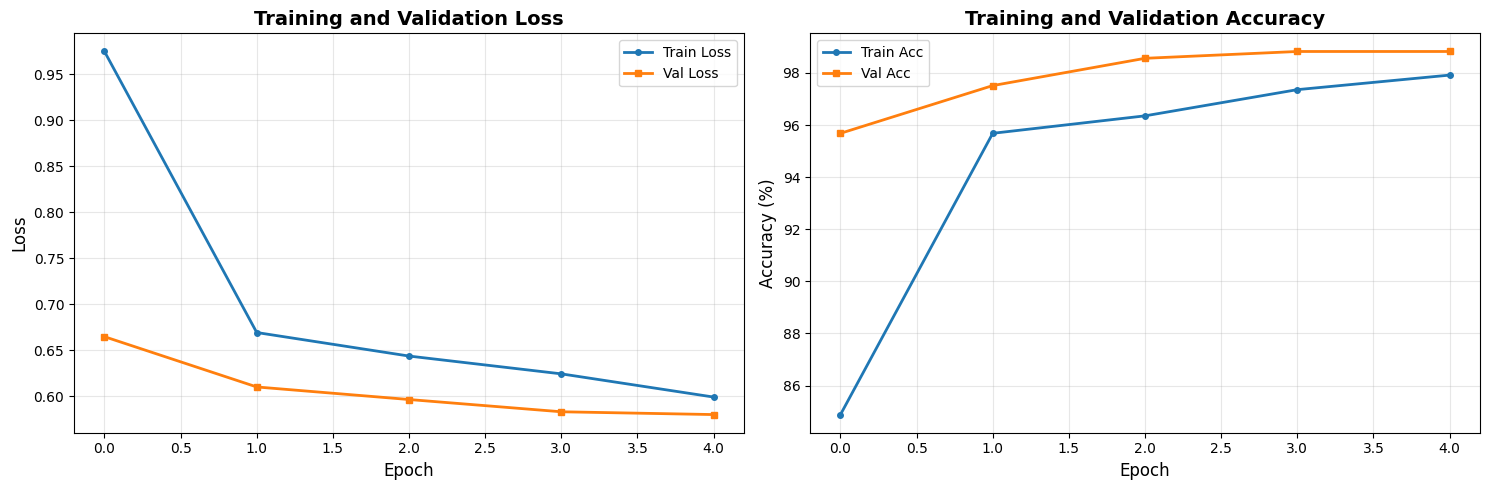


✓ Training completed!
  Best Val Acc: 98.82% at epoch 4
  Best Val Loss: 0.5834
  Checkpoints saved to: ./checkpoints
  Logs saved to: ./logs
  TensorBoard logs: ./runs/efficientnet_b3_20251125_034452


[4/6] Loading best model for evaluation...

✓ Checkpoint loaded from checkpoints/best_model.pth
  Epoch: 4
  Val Loss: 0.5834
  Val Acc: 0.9882
  Best Val Acc: 0.9882


[5/6] Evaluating on test set...

Dataset Statistics: test
Total samples: 396
Number of classes: 12

Class distribution:
  burj_khalifa                  :    39 ( 9.85%)
  chichen_itza                  :    35 ( 8.84%)
  christ_the_reedemer           :    33 ( 8.33%)
  eiffel_tower                  :    40 (10.10%)
  great_wall_of_china           :    40 (10.10%)
  machu_pichu                   :    40 (10.10%)
  pyramids_of_giza              :    38 ( 9.60%)
  roman_colosseum               :    41 (10.35%)
  statue_of_liberty             :    25 ( 6.31%)
  stonehenge                    :    22 ( 5.56%)
  taj_mahal      

Testing:   0%|          | 0/13 [00:00<?, ?it/s]


Test Accuracy: 96.97%


Classification Report:
                       precision    recall  f1-score  support
burj_khalifa            0.902439  0.948718  0.925000       39
chichen_itza            1.000000  1.000000  1.000000       35
christ_the_reedemer     0.970588  1.000000  0.985075       33
eiffel_tower            0.975000  0.975000  0.975000       40
great_wall_of_china     0.880952  0.925000  0.902439       40
machu_pichu             1.000000  0.950000  0.974359       40
pyramids_of_giza        0.974359  1.000000  0.987013       38
roman_colosseum         1.000000  0.975610  0.987654       41
statue_of_liberty       1.000000  0.960000  0.979592       25
stonehenge              1.000000  0.954545  0.976744       22
taj_mahal               1.000000  1.000000  1.000000       17
venezuela_angel_falls   1.000000  0.961538  0.980392       26
accuracy                0.969697  0.969697  0.969697        0
macro avg               0.975278  0.970868  0.972772      396
weighted avg          

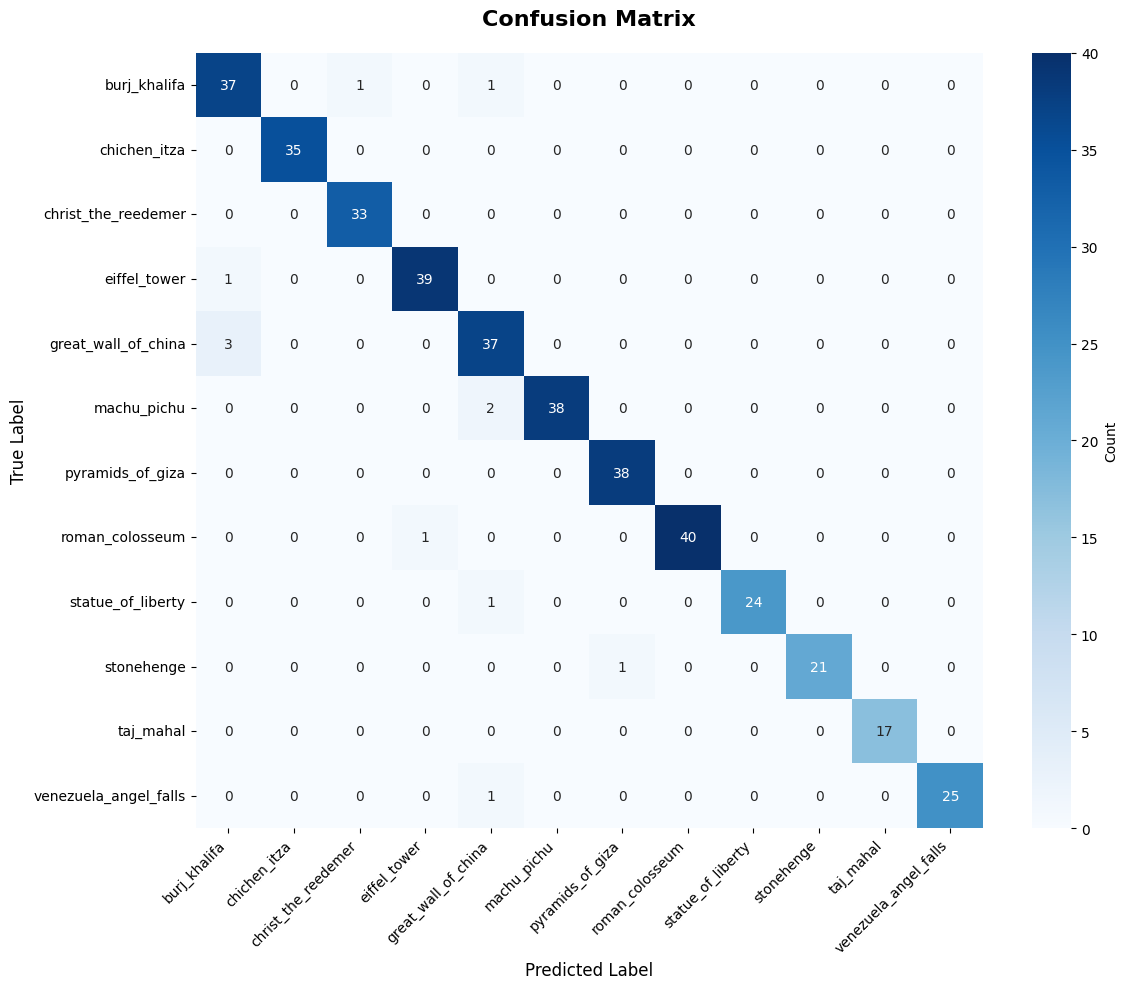

✓ Per-class metrics plot saved to logs/per_class_metrics_efficientnet_b3_20251125_034452.png


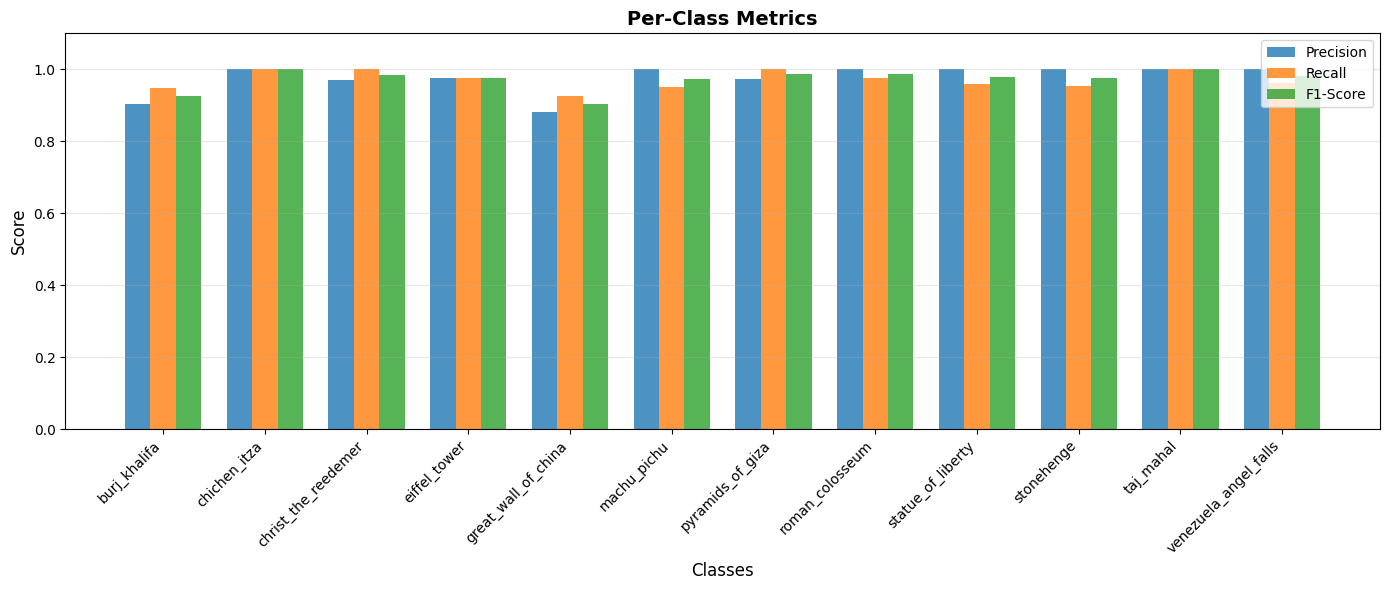

✓ Predictions saved to logs/predictions_efficientnet_b3_20251125_034452.csv

[6/6] Demo: Single image prediction

✅ Pipeline execution completed successfully!

📁 Outputs:
  • Checkpoints: ./checkpoints
  • Logs: ./logs
  • TensorBoard: ./runs/efficientnet_b3_20251125_034452

🔍 To view TensorBoard:
  tensorboard --logdir=./runs



In [43]:
if __name__ == "__main__":
    main()